In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip


In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import zipfile

# Extracting training and test data

In [3]:
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")


In [62]:
print(len(os.listdir("./train")))
print(len(os.listdir("./test1")))
# print(os.listdir("./train"))


25000
12500


# Prepare Traning Data

In [5]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,cat.3234.jpg,0
1,cat.2540.jpg,0
2,cat.10897.jpg,0
3,cat.11995.jpg,0
4,cat.678.jpg,0


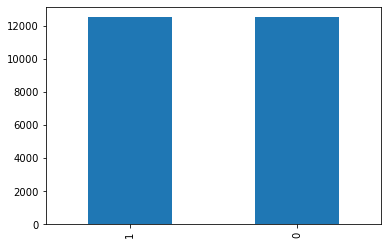

In [7]:
df['category'].value_counts().plot.bar()


# Visualize random Images

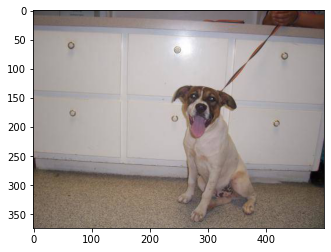

In [8]:
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)

# Get the sizes of images in the directory

In [9]:
from PIL import Image
minHeight = 10000
minWidth = 10000
for image in os.listdir("./train"):
    imageDim = Image.open("./train/"+image).size 
    if minHeight > imageDim[1]:
        minHeight = imageDim[1]
    if minWidth > imageDim[0]:
        minWidth = imageDim[0]
print("Mininum Height and Width: ", minHeight, minWidth)
    

Mininum Height and Width:  32 42


# Model

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu", input_shape=(128,128,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
          
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
          
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [12]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
earlystop = EarlyStopping(monitor="val_loss", patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
callbacks = [earlystop, learning_rate_reduction]


# Data Preparation

Because we will use image genaretor with class_mode="binary". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [18]:
print(train_df.shape)
print(validate_df.shape)

(20000, 2)
(5000, 2)


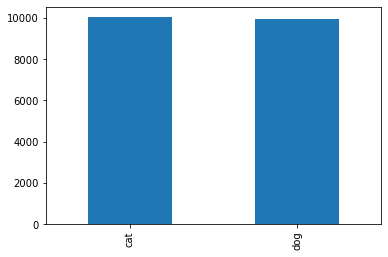

In [28]:
train_df['category'].value_counts().plot.bar()

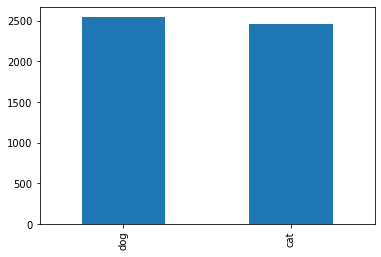

In [29]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning & Validation Generator

In [30]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           rotation_range=20,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           zoom_range=0.1,
                                                           horizontal_flip=True,
                                                           shear_range=0.1)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [31]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='binary',
    batch_size=15
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='binary',
    batch_size=15
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Fit Model

In [32]:
epochs = 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 148s 111ms/step - loss: 0.3534 - accuracy: 0.8442 - val_loss: 0.3241 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 152s 114ms/step - loss: 0.3419 - accuracy: 0.8494 - val_loss: 0.3559 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 151s 114ms/step - loss: 0.3399 - accuracy: 0.8521 - val_loss: 0.3184 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - 149s 112ms/step - loss: 0.3345 - accuracy: 0.8525 - val_loss: 0.2686 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - 148s 111ms/step - loss: 0.3301 - accuracy: 0.8550 - val_loss: 0.2380 - val_accuracy: 0.9039 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - 147s 110ms/step - loss: 0.3222 - accuracy: 0.8595 - val_loss: 0.2647 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 7/50
1333/1333 [============

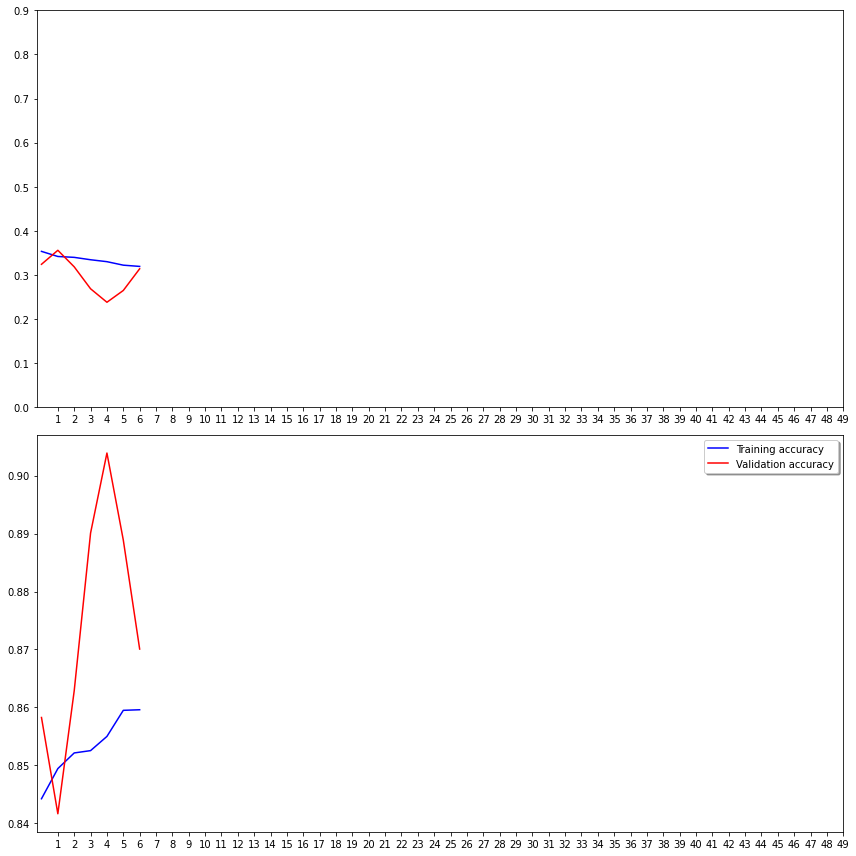

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [36]:
model.save_weights("model.h5")

# Prepare Testing Data

In [37]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [40]:
test_df.head()

,filename
0,12124.jpg
1,6960.jpg
2,6164.jpg
3,10936.jpg
4,8034.jpg


# Create Testing Generator

In [38]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [39]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [43]:
print(predict.shape)
print(predict)

(12500, 1)
[[5.0505337e-06]
 [1.3795564e-05]
 [9.2685368e-05]
 ...
 [9.9729866e-01]
 [4.8696369e-02]
 [7.9848009e-01]]


In [48]:
test_df["category"] = predict > 0.5

In [49]:
test_df.head()

,filename,category
0,12124.jpg,False
1,6960.jpg,False
2,6164.jpg,False
3,10936.jpg,True
4,8034.jpg,False


In [50]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [51]:
test_df.head()

,filename,category
0,12124.jpg,cat
1,6960.jpg,cat
2,6164.jpg,cat
3,10936.jpg,dog
4,8034.jpg,cat


In [52]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [53]:
test_df.head()

,filename,category
0,12124.jpg,0
1,6960.jpg,0
2,6164.jpg,0
3,10936.jpg,1
4,8034.jpg,0


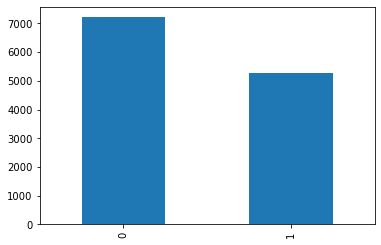

In [54]:
test_df['category'].value_counts().plot.bar()


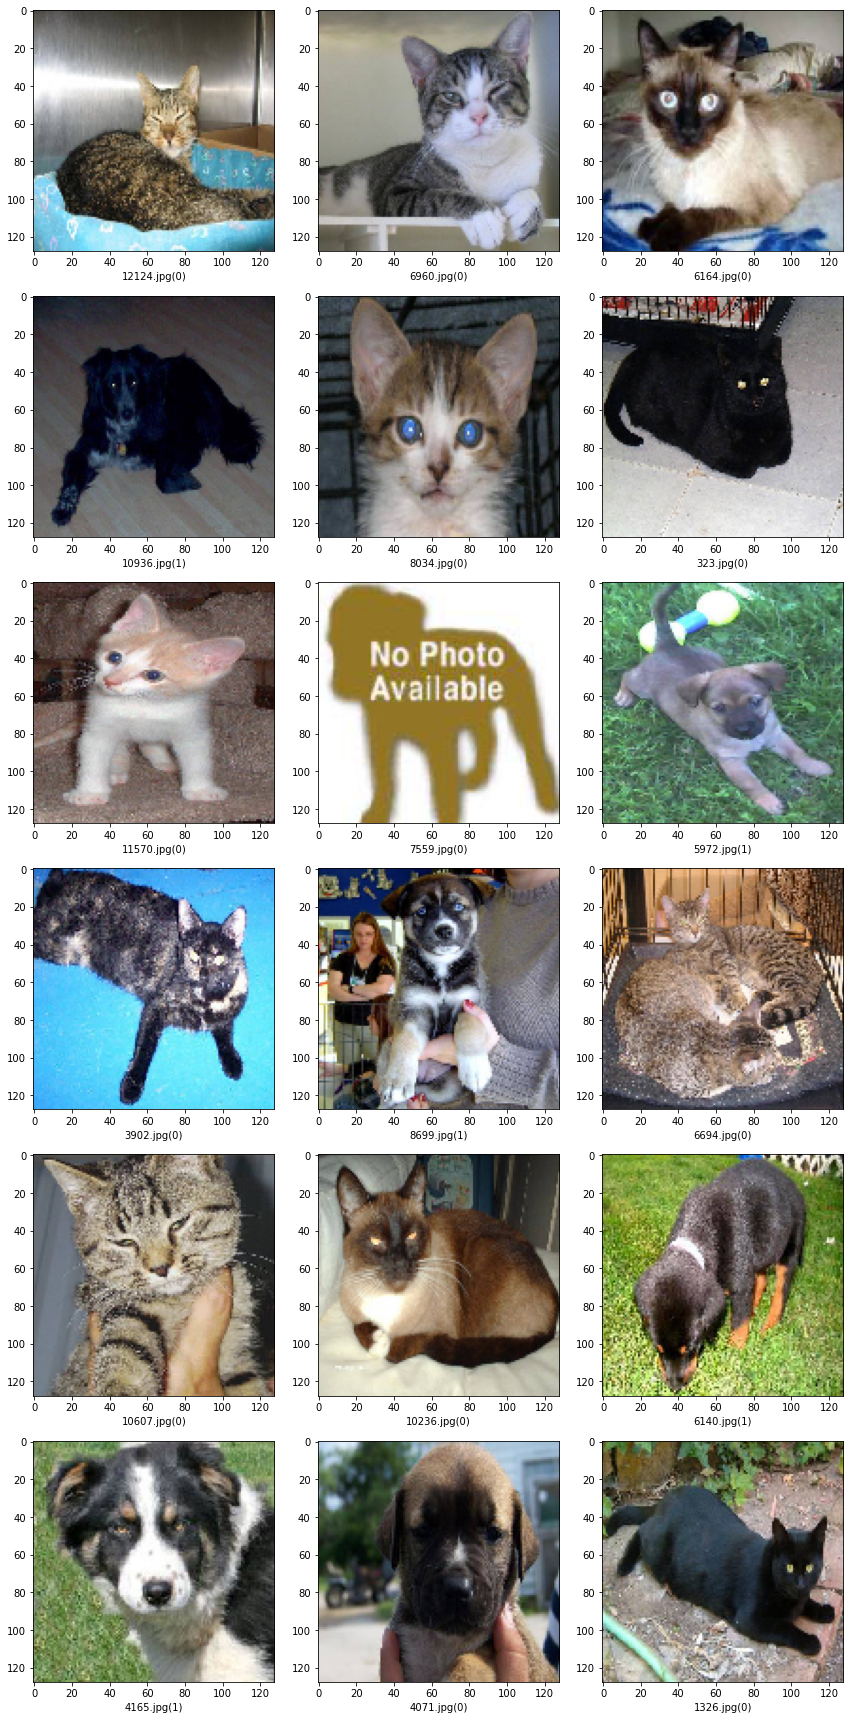

In [57]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


# Submission

In [58]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

In [59]:
submission_df.head()

,id,label
0,12124,0
1,6960,0
2,6164,0
3,10936,1
4,8034,0


In [60]:
submission_df.to_csv('submission.csv', index=False)

In [61]:
print(os.listdir("."))

['submission.csv', 'test1', '__notebook_source__.ipynb', 'train', 'model.h5']
